In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import statsmodels.api as sm
from statsmodels.genmod.families import Binomial

In [2]:
df = pd.read_csv('energy_dataset.csv')
df.head()

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
0,2015-01-01 00:00:00+01:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,...,196.0,0.0,6378.0,17.0,NaN,6436.0,26118.0,25385.0,50.10,65.41
1,2015-01-01 01:00:00+01:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,...,195.0,0.0,5890.0,16.0,NaN,5856.0,24934.0,24382.0,48.10,64.92
2,2015-01-01 02:00:00+01:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,...,196.0,0.0,5461.0,8.0,NaN,5454.0,23515.0,22734.0,47.33,64.48
3,2015-01-01 03:00:00+01:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,...,191.0,0.0,5238.0,2.0,NaN,5151.0,22642.0,21286.0,42.27,59.32
4,2015-01-01 04:00:00+01:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,...,189.0,0.0,4935.0,9.0,NaN,4861.0,21785.0,20264.0,38.41,56.04


In [3]:
# Check missing values
df.isnull().sum()

time                                               0
generation biomass                                19
generation fossil brown coal/lignite              18
generation fossil coal-derived gas                18
generation fossil gas                             18
generation fossil hard coal                       18
generation fossil oil                             19
generation fossil oil shale                       18
generation fossil peat                            18
generation geothermal                             18
generation hydro pumped storage aggregated     35064
generation hydro pumped storage consumption       19
generation hydro run-of-river and poundage        19
generation hydro water reservoir                  18
generation marine                                 19
generation nuclear                                17
generation other                                  18
generation other renewable                        18
generation solar                              

In [4]:
df = df.drop(columns=['forecast wind offshore eday ahead', 'generation hydro pumped storage aggregated'])
df = df.dropna()

Linear Model R^2: 0.19289865686606622
GLM Logistic Model R^2: 0.19524351703331966


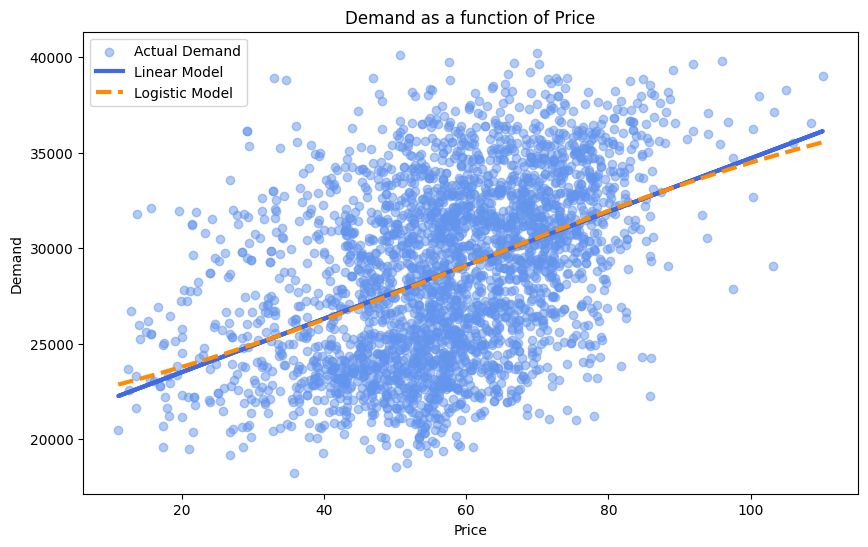

In [15]:
# Random sample of the data
df_sample = df.sample(n=3000, replace=True, random_state=42)

# Reshape the data
demand = df_sample['total load actual'].values.reshape(-1, 1)
price = df_sample['price actual'].values.reshape(-1, 1)

# Linear Regression Model
linear_model = LinearRegression()
linear_model.fit(price, demand)
linear_demand_pred = linear_model.predict(price)

# R^2 scores for Linear Regression
linear_r2 = r2_score(demand, linear_demand_pred)
print(f"Linear Model R^2: {linear_r2}")

# Generalized Linear Model with Logistic Regression

# Scaling demand to fit between 0 and 1 for the logistic regression
scaler = MinMaxScaler()
demand_scaled = scaler.fit_transform(demand)

# Fit GLM with logit link
glm_binom = sm.GLM(demand_scaled, sm.add_constant(price), family=Binomial())
glm_result = glm_binom.fit()

# Predicting on a linspace for a smoother curve
price_space = np.linspace(price.min(), price.max(), 300).reshape(-1, 1)
price_space_with_const = sm.add_constant(price_space)
logistic_demand_pred_scaled = glm_result.predict(price_space_with_const)

# Rescaling the predictions back to the original demand scale
logistic_demand_pred = scaler.inverse_transform(logistic_demand_pred_scaled.reshape(-1, 1))

# R^2 score for GLM Logistic Regression
logistic_r2 = r2_score(demand, scaler.inverse_transform(glm_result.predict(sm.add_constant(price)).reshape(-1, 1)))
print(f"GLM Logistic Model R^2: {logistic_r2}")

# Plotting both Linear and Logistic Regression results
plt.figure(figsize=(10, 6))
plt.scatter(price, demand, color='cornflowerblue', label='Actual Demand', alpha=0.5)
plt.plot(price, linear_demand_pred, color='royalblue', label='Linear Model', linewidth=3)
plt.plot(price_space, logistic_demand_pred, color='darkorange', label='Logistic Model', linewidth=3, linestyle='--')
plt.xlabel('Price')
plt.ylabel('Demand')
plt.title('Demand as a function of Price')
plt.legend()
plt.show()

In [13]:
df['time'] = pd.to_datetime(df['time'], utc=True)

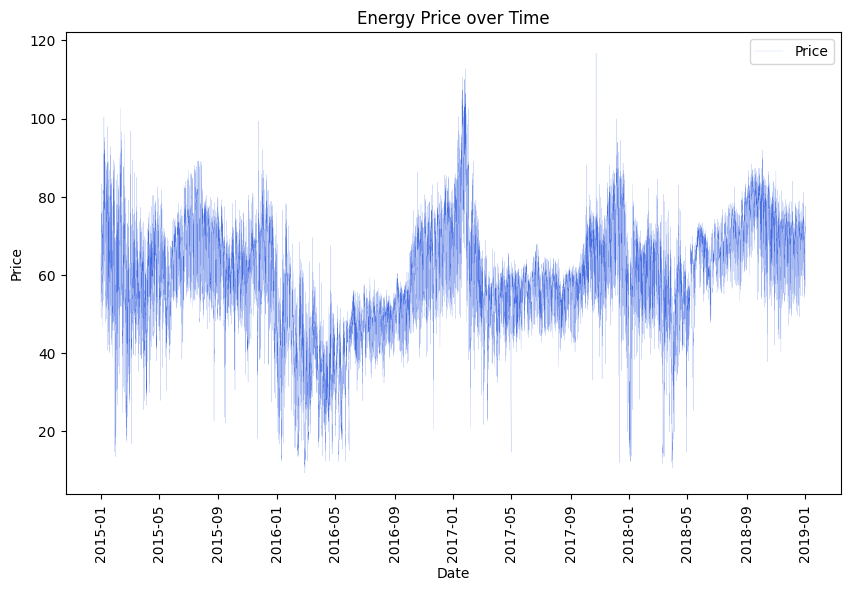

In [14]:
# Plot dynamic price
time = df['time']
demand = df['total load actual']
price = df['price actual']
plt.figure(figsize=(10,6))
plt.plot(time, price, color='royalblue', label='Price', linewidth=0.08)
plt.xlabel('Date')  
plt.ylabel('Price')
plt.title('Energy Price over Time')
plt.legend()
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=4))
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation='vertical')
plt.show()

In [7]:
supply = df[[col for col in df.columns if 'generation' in col]].sum(axis=1)
supply

0        28251.0
1        27818.0
2        26796.0
3        25223.0
4        24620.0
          ...   
35059    26415.0
35060    25213.0
35061    23987.0
35062    22748.0
35063    22605.0
Length: 35017, dtype: float64